In [2]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tslearn as ts

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Import et nettoyage des données

In [3]:
house1_power_blk2 = pd.read_csv('data/house1_power_blk2_labels.zip', index_col='datetime').interpolate('linear')
house1_power_blk2.index = pd.to_datetime(house1_power_blk2.index)
house1_power_blk2 = house1_power_blk2.asfreq('s')
#house1_power_blk2 = house1_power_blk2.loc['2016-03-06 00:00:00':'2016-03-13 00:00:00']
#house1_power_blk2 = house1_power_blk2.resample('1min').nearest()
house1_power_blk2['hour'] = house1_power_blk2.index.hour
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0
2016-03-06 00:00:01,474.0,0,0
2016-03-06 00:00:02,476.0,0,0
2016-03-06 00:00:03,476.0,0,0
2016-03-06 00:00:04,475.0,0,0


On peut essayer de voir quelle est la fenêtre de temps optimale pour nos features générées

In [4]:
scaler = MinMaxScaler()

all_windows = ['2min', '5min', '10min', '30min', '1h', '2h', '3h', '5h', '12h']

house1_power_norm = pd.DataFrame()
house1_power_norm['activity'] = house1_power_blk2['activity'].values
house1_power_norm['mains_scaled'] = scaler.fit_transform(house1_power_blk2['mains'].values.reshape(-1,1))
house1_power_norm['diff_scaled'] = scaler.fit_transform(house1_power_blk2['mains'].diff(1).values.reshape(-1,1))
house1_power_norm['hour_scaled'] = scaler.fit_transform(house1_power_blk2['hour'].values.reshape(-1,1))

for rolling_window in all_windows:
    df_rolling = house1_power_blk2['mains'].rolling(rolling_window)
    house1_power_norm['mean_'+rolling_window+'_scaled'] = scaler.fit_transform(df_rolling.mean().values.reshape(-1,1))
    house1_power_norm['std_'+rolling_window+'_scaled'] = scaler.fit_transform(df_rolling.std().values.reshape(-1,1))
    house1_power_norm['maxmin_'+rolling_window+'_scaled'] = scaler.fit_transform(df_rolling.max().values.reshape(-1,1)-df_rolling.min().values.reshape(-1,1))

house1_power_norm = house1_power_norm.dropna()

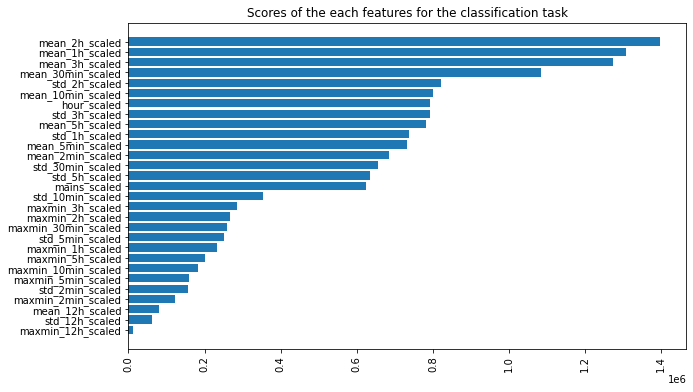

In [5]:
# ideally this would be done after a split test / train
fs = SelectKBest()
all_features = ['mains_scaled', 'hour_scaled'] + [func+rw+'_scaled' for rw in all_windows for func in ['std_', 'mean_', 'maxmin_']]
fs.fit_transform(house1_power_norm.loc[:, all_features].values, house1_power_norm.loc[:, 'activity'].values)

sorted_scores_idx = np.argsort(fs.scores_)
#features = np.array([str(i) for i in sorted_scores_idx])
fig = plt.figure(figsize=(10, 6))
plt.barh(y=np.array(all_features)[sorted_scores_idx], width=fs.scores_[sorted_scores_idx]);
#plt.bar(x=range(len(fs.scores_)), height=fs.scores_);
plt.xticks(rotation=90)
plt.title('Scores of the each features for the classification task');

2 heures semble optimal, mais 1 heure semble aussi bien fonctionner et cette durée a l'air plus adaptée pour la maison 2. Nous allons donc choisir une fenêtre de 1 heure.

In [6]:
best_window = '1h'
features_col = ['mains_scaled', 'hour_scaled'] + [func+best_window+'_scaled' for func in ['std_', 'mean_', 'maxmin_']]

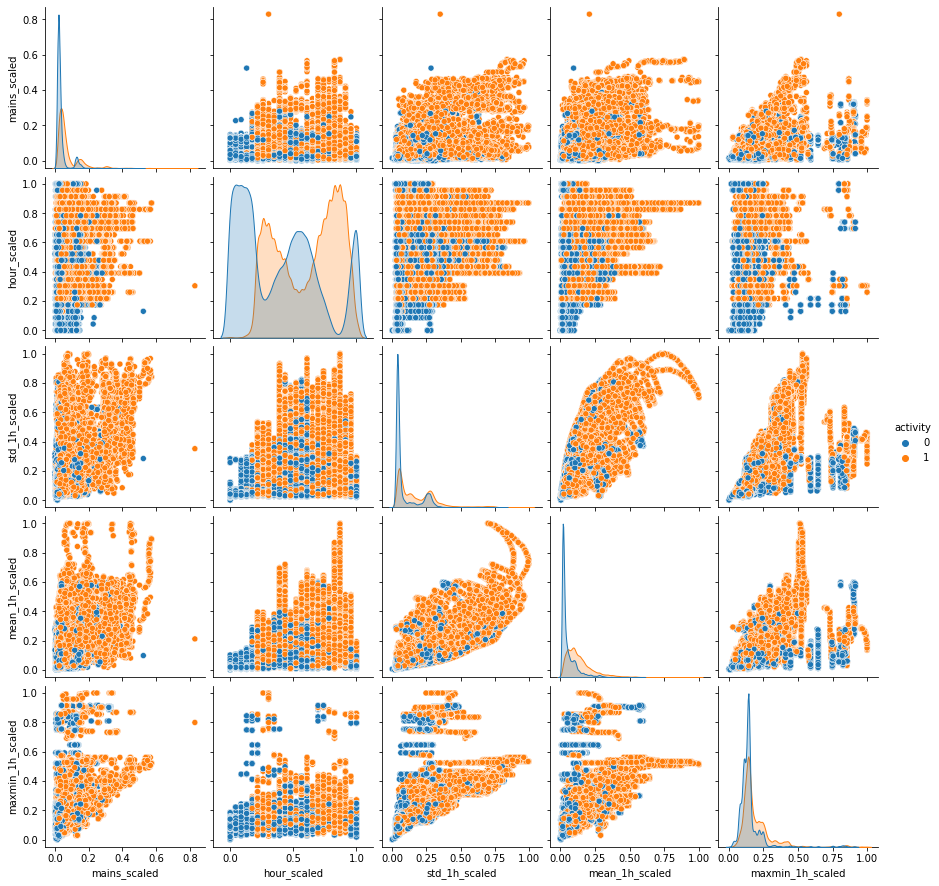

In [7]:
sns.pairplot(house1_power_norm[features_col + ['activity']].sample(frac=0.1), hue='activity');

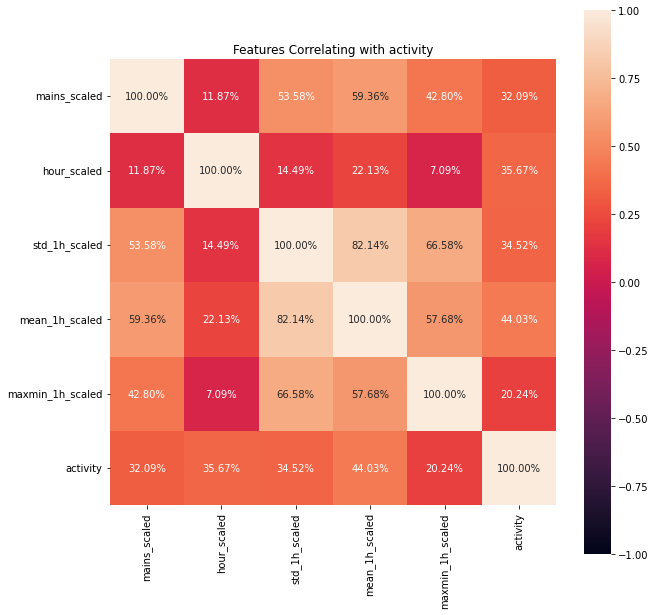

In [8]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(house1_power_norm[features_col + ['activity']].corr(), vmin=-1, vmax=1, annot=True, fmt='.2%', square=True)
ax.set_title('Features Correlating with activity');

# 2. Train / test split

In [9]:
def split_train_test_indexes(data, percentage=0.3):
    # tirage de jours aléatoires
    delta_time = data.index[-2] - data.index[0]
    nb_days = int(delta_time.days * percentage)
    random_dates = data.index[0] + pd.to_timedelta(np.random.choice(delta_time.days, nb_days, replace=False), unit='day')

    data_freq = pd.Timedelta(data.index.freq).seconds if data.index.freq else 1
    # définition des indexes test, train
    test_indexes = pd.DatetimeIndex(np.array([pd.date_range(d, periods=24*60*60/data_freq, freq=data.index.freq) for d in random_dates]).ravel())
    train_indexes = data.index[~np.isin(data.index, test_indexes)]

    return train_indexes, test_indexes

In [18]:
# on tire les test / train
best_window = '1h'
features_col = ['mains_scaled', 'hour_scaled'] + [func+best_window+'_scaled' for func in ['std_', 'mean_', 'maxmin_']]
train_indexes, test_indexes = split_train_test_indexes(house1_power_blk2, 0.3)

In [11]:
scaler = MinMaxScaler()

# mains_scaled
scaler = scaler.fit(house1_power_blk2.loc[train_indexes, 'mains'].values.reshape(-1,1))
house1_power_blk2['mains_scaled'] = scaler.transform(house1_power_blk2['mains'].values.reshape(-1,1))

# # diff_scaled
# minmax = scaler.fit(house1_power_blk2.loc[train_indexes, 'mains'].diff(1).values.reshape(-1,1))
# house1_power_blk2['diff_scaled' ] = minmax.transform(house1_power_blk2['mains'].diff(1).values.reshape(-1,1))

# mean_scaled
scaler = scaler.fit(house1_power_blk2.loc[train_indexes, 'mains'].rolling(best_window).mean().values.reshape(-1,1))
house1_power_blk2['mean_'+best_window+'_scaled'] = scaler.transform(house1_power_blk2['mains'].rolling(best_window).mean().values.reshape(-1,1))

# std_scaled
scaler = scaler.fit(house1_power_blk2.loc[train_indexes, 'mains'].rolling(best_window).std().values.reshape(-1,1))
house1_power_blk2['std_'+best_window+'_scaled'] = scaler.transform(house1_power_blk2['mains'].rolling(best_window).std().values.reshape(-1,1))

# maxmin_scaled
scaler = scaler.fit(house1_power_blk2.loc[train_indexes, 'mains'].rolling(best_window).std().values.reshape(-1,1))
house1_power_blk2['maxmin_'+best_window+'_scaled'] = scaler.transform(house1_power_blk2['mains'].rolling(best_window).max().values.reshape(-1,1) - house1_power_blk2['mains'].rolling(best_window).min().values.reshape(-1,1))

# hour_scaled
scaler = scaler.fit(house1_power_blk2.loc[train_indexes, 'hour'].values.reshape(-1,1))
house1_power_blk2['hour_scaled'] = scaler.transform(house1_power_blk2['hour'].values.reshape(-1,1))

house1_power_blk2 = house1_power_blk2.fillna(method='bfill')

In [12]:
# on génère les X/y train/test
X_train, X_test = house1_power_blk2.loc[train_indexes, features_col].values, house1_power_blk2.loc[test_indexes, features_col].values
y_train, y_test = house1_power_blk2.loc[train_indexes, 'activity'].values, house1_power_blk2.loc[test_indexes, 'activity'].values

# 3. Algorithmes généraux

In [13]:
from sklearn.metrics import fbeta_score, accuracy_score

def plot_scores_param(X_train, X_test, y_train, y_test, estimator, param_name, param_range, other_params={}):
    f2_score = []
    score = []
    for p in param_range:
        classifier = estimator(**{param_name:p}, **other_params)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        f2_score.append((fbeta_score(y_test, y_pred, average='macro', beta=0.5)))
        score.append(accuracy_score(y_test, y_pred))

        print(f"tested {param_name}={p} ...")

    best_param = np.argmax(f2_score)

    plt.figure(figsize=(10, 6));
    plt.plot(param_range, score, label='score', color='grey', linestyle='dashed');
    plt.plot(param_range, f2_score, label='fb score');
    plt.scatter(param_range[best_param], f2_score[best_param], label='fb max', marker='x', s=100, color='red')
    plt.legend();
    plt.title('fb and score = f({})'.format(param_name));
    plt.show();

    print('Meilleur fb score={:.2f} obtenu pour {}={:.2f}'.format(f2_score[best_param], param_name, param_range[best_param]))

    classifier = estimator(**{param_name:param_range[best_param]})
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    sns.heatmap(pd.crosstab(y_test, y_pred, normalize=True), annot=True, fmt='.1%', vmin=0, vmax=1, cmap=sns.cm.rocket_r);
    plt.xlabel('vérité');
    plt.ylabel('prédiction');
    plt.title('Resultats avec {}={:.2f}'.format(param_name, param_range[best_param]));
    plt.show();

    return param_name, param_range[best_param], f2_score[best_param]

0.7386788278731478
0.7393518518518518


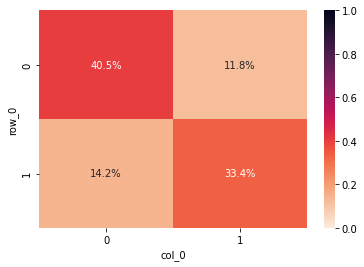

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
print(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
print(accuracy_score(y_test, y_pred))
sns.heatmap(pd.crosstab(y_test, y_pred, normalize=True), annot=True, fmt='.1%', vmin=0, vmax=1, cmap=sns.cm.rocket_r);

tested n_neighbors=1 ...
tested n_neighbors=30 ...
tested n_neighbors=60 ...
tested n_neighbors=90 ...
tested n_neighbors=120 ...


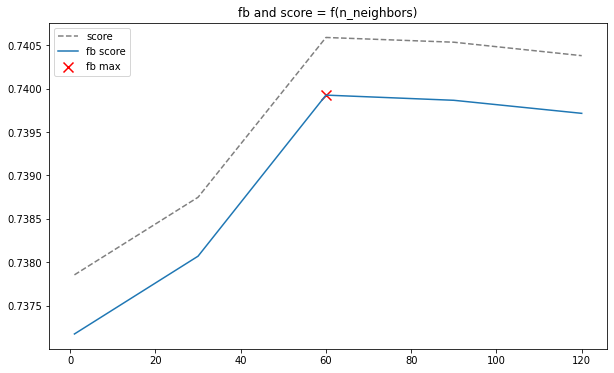

Meilleur fb score=0.74 obtenu pour n_neighbors=60.00


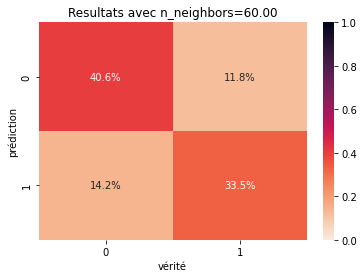

In [20]:
from sklearn.neighbors import KNeighborsClassifier

k_range = [1, 30, 60, 90, 120]
plot_scores_param(X_train, X_test, y_train, y_test, KNeighborsClassifier, 'n_neighbors', k_range);

tested n_estimators=1 ...
tested n_estimators=30 ...
tested n_estimators=60 ...
tested n_estimators=90 ...


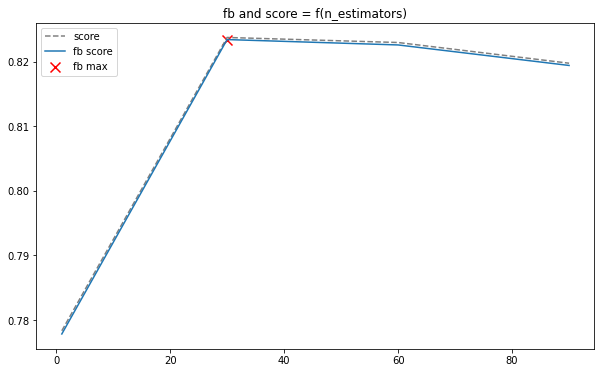

Meilleur fb score=0.82 obtenu pour n_estimators=30.00


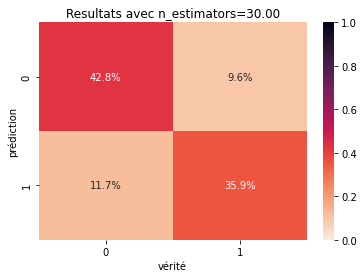

In [21]:
from sklearn.ensemble import RandomForestClassifier

n_range = [1, 30, 60, 90]
plot_scores_param(X_train, X_test, y_train, y_test, RandomForestClassifier, 'n_estimators', n_range, other_params={'n_jobs': -1, 'max_samples': 0.8, 'max_depth': 10});

tested n_estimators=1 ...
tested n_estimators=5 ...
tested n_estimators=10 ...
tested n_estimators=20 ...


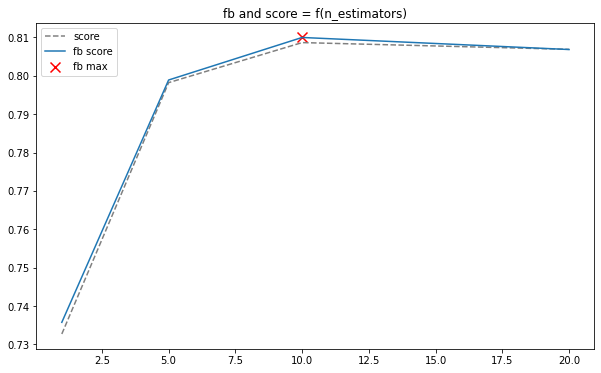

Meilleur fb score=0.81 obtenu pour n_estimators=10.00


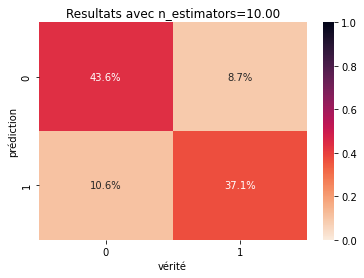

('n_estimators', 10, 0.8099865730857714)

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

n_range = [1, 5, 10, 20]
plot_scores_param(X_train, X_test, y_train, y_test, AdaBoostClassifier, 'n_estimators', n_range, other_params={'base_estimator': DecisionTreeClassifier(max_depth=2)})

# 3. Algorithmes sur Time Series

In [34]:
from tslearn.utils import to_time_series
from tslearn.preprocessing import TimeSeriesScalerMinMax

X_train, X_test = to_time_series(house1_power_blk2.loc[train_indexes, 'mains']), to_time_series(house1_power_blk2.loc[test_indexes, 'mains'])
y_train, y_test = house1_power_blk2.loc[train_indexes, 'activity'].values, house1_power_blk2.loc[test_indexes, 'activity'].values

scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import fbeta_score, accuracy_score

knn = KNeighborsTimeSeriesClassifier(n_neighbors=3)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
print(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
print(accuracy_score(y_test, y_pred))

In [ ]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import fbeta_score, accuracy_score

scores = []
fb_scores = []
k_range = range(1, 4)
for k in range(1, 4):
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=k)
    knn.fit(X_train, y_train.ravel())
    y_pred = knn.predict(X_test)
    fb_scores.append(fbeta_score(y_test, y_pred, average='macro', beta=0.5))
    scores.append(accuracy_score(y_test, y_pred))

best_param = np.argmax(fb_scores)

plt.figure(figsize=(10, 6));
plt.plot(k_range, scores, label='score', color='grey', linestyle='dashed');
plt.plot(k_range, fb_scores, label='fb score');
plt.scatter(k_range[best_param], fb_scores[best_param], label='fb min', marker='x', s=100, color='red')
plt.legend();
plt.title('fb and score = f(k)');
plt.show();

print('Meilleur fb score={:.2f} obtenu pour b={:.2f}'.format(fb_scores[best_param], k_range[best_param]))

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', cmap='turbo');
plt.title('Resultats avec b={:.2f}'.format(k_range[best_param]));
plt.show();


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from dtw import dtw

def dtw_dist(x,y):
    d = dtw(x, y)
    return d.distance

knn = KNeighborsClassifier(n_neighbors=3, metric=dtw_dist)
knn.fit(X_train.ravel().reshape((-1,1)), y_train.round().ravel())
knn.score(X_test.ravel().reshape((-1,1)), y_test.round().ravel())